In [155]:
import numpy as np
import pandas as pd
from scipy.special import logit,expit
import matplotlib.pyplot as plt

In [143]:
N=3000
P=2

In [118]:
data=pd.read_csv('wagedata.csv')

In [159]:
data0=pd.read_csv('Wage.csv')

In [119]:
data.head()

,num,year,age,race,education,jobclass,health,health_ins,Y
0,1,2006,18,1,1,1,1,2,0.0
1,1,2004,24,1,4,2,2,2,0.0
2,1,2003,45,1,3,1,1,1,0.0
3,1,2003,43,3,4,2,2,1,0.0
4,1,2005,50,1,2,2,1,1,0.0


In [120]:
Y=np.array(data['Y'])

In [142]:
SAM=np.array(data.loc[:,['num','age']])
asx=(SAM[:,1]-np.mean(SAM[:,1]))/(np.std(SAM[:,1]))
X=np.array([SAM[:,0],asx]).T

In [122]:
#np.array(np.where(Y==1)).shape
'''
SAM=np.array(data.loc[:,['num','age']])
asx=(SAM[:,1]-np.mean(SAM[:,1]))/(np.std(SAM[:,1]))
X=np.array([SAM[:,0],asx]).T
'''

"\nSAM=np.array(data.loc[:,['num','age']])\nasx=(SAM[:,1]-np.mean(SAM[:,1]))/(np.std(SAM[:,1]))\nX=np.array([SAM[:,0],asx]).T\n"

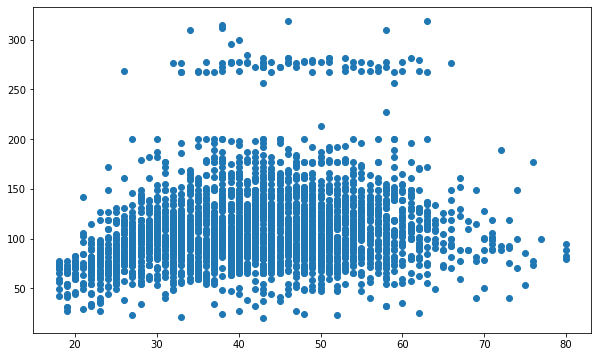

In [167]:
plt.figure(figsize=(10,6))
plt.scatter(data0['age'],data0['wage'])
plt.show()

In [123]:
#E-step
def Lih(X,beta):
    Ga=np.zeros((N,2))

    for i in range(N):#响应度
        if Y[i]==1:
            Ga[i,0]=0
            Ga[i,1]=1
        elif Y[i]==0:
            a=(expit(np.dot(X[i],beta[0])))
            b=(1-a)*(1-expit(np.dot(X[i],beta[1])))
            Ga[i,0]=a/(a+b)
            Ga[i,1]=1-Ga[i,0]

    return Ga


#M-step
def Q(X,Y,beta):
    Ga=Lih(X,beta)
    A=np.zeros(N)
    for i in range(N):
        pi=expit(np.dot(beta[0],X[i]))
        phi=expit(np.dot(beta[1],X[i]))
        if Y[i]==0:
            A[i]=(Ga[i,0])*np.log(pi)+(Ga[i,1])*np.log((1-pi)*(1-phi))
            #A[i]=Ga[i,0]*np.log(pi)+Ga[i,1]*np.log((1-pi)*(1-phi))
            #A[i]=(Ga[i,0]*np.log(pi))+(Ga[i,1]*(np.log(1-pi)+np.log(1-phi)))
        else:
            A[i]=(Ga[i,1])*np.log((1-pi)*(phi))
            #A[i]=Ga[i,0]*np.log(pi)+Ga[i,1]*np.log((1-pi)*(1-phi))
            #A[i]=(Ga[i,0]*np.log(pi))+(Ga[i,1]*(np.log(1-pi)+np.log(phi)))
        #A[i]=(Ga[i,0]*(1-Y[i])*np.log(pi))+(Ga[i,1]*(np.log(1-pi)+np.log(1-phi)+Y[i]*np.dot(X[i],beta[1])))
    Q=np.sum(A)
    return Q

def grad(X,Y,Ga,beta):
    A=np.zeros((N,P))
    B=np.zeros((N,P))
    for i in range(N):
        A[i]=((Ga[i,0]*(1-Y[i]))*(1-expit(np.dot(beta[0],X[i])))-(Ga[i,1]*expit(np.dot(beta[0],X[i]))))*X[i]
        B[i]=(Ga[i,1]*(Y[i]-expit(np.dot(beta[1],X[i]))))*X[i]
    grad1=np.sum(A,axis=0)
    grad2=np.sum(B,axis=0)
    grad=np.array([grad1,grad2])
    return grad


#EM
def dgra(X,Y,ibeta,n=1000,t=0.001,xim=0.99,yim=0.1):#梯度下降（回溯梯度下降法）xim为步长缩小倍数

    L=Lih(X,ibeta)
    for i in range(n):#M-step
        lik1=Q(X,Y,ibeta)
        ibeta1=ibeta
        L=Lih(X,ibeta)#E-step
        ibeta=ibeta+t*grad(X,Y,L,ibeta)
        lik=Q(X,Y,ibeta)
        d=np.r_[ibeta[0],ibeta[1]]
        c=np.dot(d,d)
        b=(lik-lik1)
        print('i=',i,'b=',b,'\tstep=',t)
        print('Q=',Q(X,Y,ibeta))
        if b>=yim*t*c :
            t=xim*t
        else:
            break
    return ibeta


#def dgra1(X,Y,ibeta,n=1000,a=0.01,yim=0.2,zim=0.001):
    
    for i in range(n):
        lik1=Q(X,Y,ibeta)
        L=Lih(X,ibeta)#E-step
        ibeta=ibeta+a*grad(X,Y,L,ibeta)
        lik=Q(X,Y,ibeta)
        d=np.r_[ibeta[0],ibeta[1]]
        c=np.dot(d,d)
        b=(lik-lik1)
        if b>=yim*a*c:
            a=0.5*a
        if c<=zim:
            break
    return ibeta

In [151]:
beta01=[3.75,1]
beta02=[5,1]
beta0=np.array([beta01,beta02])
Q(X,Y,beta0)

-447.778030177502

In [152]:
beta0

array([[3.75, 1.  ],
       [5.  , 1.  ]])

In [153]:
beta0=np.array([[ 3.72240647 ,-0.43155815],[ 4.99949033 , 1.00211884]])

In [154]:
EMbeta=beta0
for i in range(3):
    lik1=Q(X,Y,EMbeta)
    EMbeta=dgra(X,Y,EMbeta)
    lik=Q(X,Y,EMbeta)
    print(i)
    print(EMbeta,Q(X,Y,EMbeta))

i= 0 b= -0.0018596619474351428 	step= 0.001
Q= -364.86869261089106
0
[[ 3.72010221 -0.42799747]
 [ 4.99942942  1.0023254 ]] -364.86869261089106
i= 0 b= -0.0030469360656297795 	step= 0.001
Q= -364.8717395469567
1
[[ 3.71785847 -0.4246789 ]
 [ 4.99936619  1.00253488]] -364.8717395469567
i= 0 b= -0.00402359331661728 	step= 0.001
Q= -364.8757631402733
2
[[ 3.71567915 -0.42158311]
 [ 4.99930075  1.00274712]] -364.8757631402733
